In [76]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj
from qucat import Network,L,J,C
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from scipy.optimize import fsolve
from modeling.qubits.clockmon.libraries.clockmon_library_2ports import clockmon_cqr_to_ground, clockmon_coupling_libraries
import scqubits as scq
from modeling.resonance_fit import ResFit

In [ ]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.4e9, 7.2e9, 7.6e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array([7.0e9, 6.8e9])
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma_a = 91e-15
c_sigma_s = 100e-15

chi = 0.5e6
kappa_target = 1e6
qubit_freq_target = [5e9, 4.5e9, 5.1e9]

g_coupling_target = 90e6
Js1a = g_coupling_target**2*(qubit_freq_target[0] + qubit_freq_target[2] - 2*cplr_freq_target[0]) / (2*(qubit_freq_target[0] - cplr_freq_target[0]) * (qubit_freq_target[2] - cplr_freq_target[0]))
Js2a = g_coupling_target**2*(qubit_freq_target[1] + qubit_freq_target[2] - 2*cplr_freq_target[1]) / (2*(qubit_freq_target[1] - cplr_freq_target[1]) * (qubit_freq_target[2] - cplr_freq_target[1]))

Lj_s1, Lj_s2, Lj_a, c_c_s1_a_sensing_side, c_c_s1_a_ancilla_side, c_c_s2_a_sensing_side, c_c_s2_a_ancilla_side, c_r_s1, c_r_s2, c_r_a, g_s1, g_s2, g_a, ck_s1, ck_s2, ck_a = np.load("params.npy")
def get_g(EC, Ej, c_coupling, c_r, wr):
    # From Manenti and Motta book
    g = EC/ (e_charge) * (Ej/EC/2)**(1/4) * c_coupling / (c_r) * np.sqrt(2*planck_h * wr * (c_r))
    return g

# Readout structure for S1

In [ ]:
fl_traits = pd.read_csv("detection_device_2s_1a_00.csv").values[0][1:]
a = 10
b = 6

transmission_line_tee_points_s1 = [
    float(fl_traits[0]), # lp to input capacitor
    fl_traits[1] + (a + 2*b)/2, # input capacitor to tee
    fl_traits[2] + fl_traits[3] + fl_traits[4] + (a + 2*b), # tee to split point
    fl_traits[5] + (a + 2*b)/2, # split point to lp
    30 + fl_traits[6] + fl_traits[7] # split point to ground

]

cap_to_ground = digit_tee_ck_to_ground()

cfl = 3e-14
cfl_to_ground = cap_to_ground(cfl)
cks_to_ground_s1 = cap_to_ground(ck_s1)

ck_given_coupling = get_ck(type = "smooth_capacitor")
finger_control_feedline = ck_given_coupling(cfl)
print(f"Finger control probeline capacitor: {finger_control_feedline:.5}")


ck_given_coupling = get_ck(type = "digittee")
finger_control_feedline = ck_given_coupling(ck_s1)
print(f"Finger control readout resonator: {finger_control_feedline:.5}")

Finger control probeline capacitor: 3.4432
Finger control readout resonator: 1.867


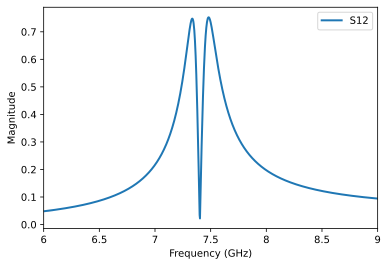

In [ ]:
resonator_capacitance = c_rr[0] -ck_s1 -  c_r_s1
options_s1 = {
    "qubit_c": [c_sigma_s],
    "qubit_l": [Lj_s1],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[0]],
    "ck": [ck_s1],
    "ck_to_ground": [cks_to_ground_s1],
    "cqr": [c_r_s1],
    "feedline_traits": transmission_line_tee_points_s1,
    "cfl": cfl,
    "cfl_to_ground": cap_to_ground(cfl),
    "frequency": [6, 9],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a*1e-6,
    "b": b*1e-6,
    "ep_r": ep_r
}
cnx = assemble_network(options_s1)
cir = rf.Circuit(cnx)

# cir.plot_graph(network_labels=True, network_fontsize=15,
#                port_labels=True, port_fontsize=15,
#                edge_fontsize=10)
ntw = cir.network
plt.figure(figsize = (6, 4))
ntw.plot_s_mag(m=0, n=1, lw=2)

# T1 Purcell for S1

In [ ]:
options_purcell_s1 = {
    "qubit_c": [c_sigma_s],
    "qubit_l": [Lj_s1],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[0]],
    "ck": [ck_s1],
    "ck_to_ground": [cks_to_ground_s1],
    "cqr": [c_r_s1],
    "feedline_traits": transmission_line_tee_points_s1,
    "cfl": cfl,
    "cfl_to_ground": cfl_to_ground,
    "frequency": [4.9, 5.1],
    "n_points": 3001,
    "type": "T1_Purcell_estimation",
    "decay_source": "readout_system",
    "a": a*1e-6,
    "b": b*1e-6,
    "ep_r": ep_r
}
cnx = assemble_network(options_purcell_s1)
cir = rf.Circuit(cnx)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network

In [113]:
freq_span_s1 = np.linspace(options_purcell_s1["frequency"][0], options_purcell_s1["frequency"][1], options_purcell_s1["n_points"])
qb_idx = np.argmin(abs(freq_span_s1 - qubit_freq_target[0]/1e9))
Y_real_s1 = ntw.y[qb_idx, 0, 0].real
T1_s1_readout_purcell_limit = c_sigma_s/Y_real_s1
print(f"T1_s1_readout_purcell_limit: {T1_s1_readout_purcell_limit*1e6} us")

T1_s1_readout_purcell_limit: 15384.910009000243 us


In [116]:
# T1 Purcell - adapting the formula to the filter presence (eq. 178 of https://doi.org/10.1063/1.5089550):
g = g_s1 * 2*np.pi
purcell_Q = 15 # should be found from fitting.
delta = (rr_freq_target - 5e9)*2*np.pi
k_purcell_ = kappa_target* (g/delta)**2 
gamma_purcell = k_purcell_ * qubit_freq_target[0]*2*np.pi / (2*purcell_Q*delta)

T1_purcell = 1/gamma_purcell[0]
print(T1_purcell*1e6)

20994.338832854177


# Readout structure for S2

In [120]:
fl_traits = pd.read_csv("detection_device_2s_1a_00.csv").values[1][1:]
a = 10
b = 6

transmission_line_tee_points_s2 = [
    float(fl_traits[0]), # lp to input capacitor
    fl_traits[1] + (a + 2*b)/2, # input capacitor to tee
    fl_traits[2] + fl_traits[3] + fl_traits[4] + (a + 2*b), # tee to split point
    fl_traits[5] + (a + 2*b)/2, # split point to lp
    30 + fl_traits[6] + fl_traits[7] # split point to ground

]

cap_to_ground = digit_tee_ck_to_ground()

cfl = 3e-14
cfl_to_ground = cap_to_ground(cfl)
cks_to_ground_s2 = cap_to_ground(ck_s2)

ck_given_coupling = get_ck(type = "smooth_capacitor")
finger_control_feedline = ck_given_coupling(cfl)
print(f"Finger control probeline capacitor: {finger_control_feedline:.5}")


ck_given_coupling = get_ck(type = "digittee")
finger_control_feedline = ck_given_coupling(ck_s2)
print(f"Finger control readout resonator: {finger_control_feedline:.5}")

Finger control probeline capacitor: 3.4432
Finger control readout resonator: 1.8989


In [92]:
l_rr

array([1.71967039e-09, 1.76743901e-09, 1.67441590e-09])

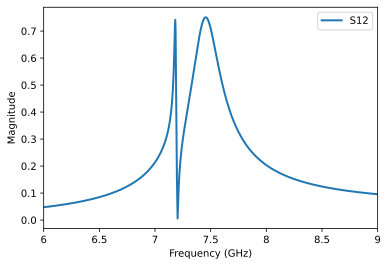

In [121]:
resonator_capacitance = c_rr[1] -ck_s2 -  c_r_s2
options_s2 = {
    "qubit_c": [c_sigma_s],
    "qubit_l": [Lj_s2],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[1]],
    "ck": [ck_s2],
    "ck_to_ground": [cks_to_ground_s2],
    "cqr": [c_r_s2],
    "feedline_traits": transmission_line_tee_points_s2,
    "cfl": cfl,
    "cfl_to_ground": cap_to_ground(cfl),
    "frequency": [6, 9],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a*1e-6,
    "b": b*1e-6,
    "ep_r": ep_r
}
cnx = assemble_network(options_s2)
cir = rf.Circuit(cnx)

# cir.plot_graph(network_labels=True, network_fontsize=15,
#                port_labels=True, port_fontsize=15,
#                edge_fontsize=10)
ntw = cir.network
plt.figure(figsize = (6, 4))
ntw.plot_s_mag(m=0, n=1, lw=2)

# T1 Purcell for S2

In [122]:
resonator_capacitance = c_rr[1] -ck_s2 -  c_r_s2

options_purcell_s2 = {
    "qubit_c": [c_sigma_s],
    "qubit_l": [Lj_s2],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[1]],
    "ck": [ck_s2],
    "ck_to_ground": [cks_to_ground_s2],
    "cqr": [c_r_s1],
    "feedline_traits": transmission_line_tee_points_s2,
    "cfl": cfl,
    "cfl_to_ground": cfl_to_ground,
    "frequency": [4.1, 5],
    "n_points": 3001,
    "type": "T1_Purcell_estimation",
    "decay_source": "readout_system",
    "a": a*1e-6,
    "b": b*1e-6,
    "ep_r": ep_r
}
cnx = assemble_network(options_purcell_s1)
cir = rf.Circuit(cnx)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network

In [123]:
freq_span_s2 = np.linspace(options_purcell_s2["frequency"][0], options_purcell_s2["frequency"][1], options_purcell_s2["n_points"])
qb_idx = np.argmin(abs(freq_span_s2 - qubit_freq_target[1]/1e9))
Y_real_s2 = ntw.y[qb_idx, 0, 0].real
T1_s2_readout_purcell_limit = c_sigma_s/Y_real_s2
print(f"T1_s1_readout_purcell_limit: {T1_s2_readout_purcell_limit*1e6} us")

T1_s1_readout_purcell_limit: 15923.098986366233 us


# Readout structure for A

In [126]:
fl_traits = pd.read_csv("detection_device_2s_1a_00.csv").values[2][1:]
a = 10
b = 6

transmission_line_tee_points_a = [
    float(fl_traits[0]), # lp to input capacitor
    fl_traits[1] + (a + 2*b)/2, # input capacitor to tee
    fl_traits[2] + fl_traits[3] + fl_traits[4] + (a + 2*b), # tee to split point
    fl_traits[5] + (a + 2*b)/2, # split point to lp
    30 + fl_traits[6] + fl_traits[7] # split point to ground

]

cap_to_ground = digit_tee_ck_to_ground()

cfl = 3e-14
cfl_to_ground = cap_to_ground(cfl)
cks_to_ground_a = cap_to_ground(ck_s1)

ck_given_coupling = get_ck(type = "smooth_capacitor")
finger_control_feedline = ck_given_coupling(cfl)
print(f"Finger control probeline capacitor: {finger_control_feedline:.5}")


ck_given_coupling = get_ck(type = "digittee")
finger_control_feedline = ck_given_coupling(ck_s1)
print(f"Finger control readout resonator: {finger_control_feedline:.5}")

Finger control probeline capacitor: 3.4432
Finger control readout resonator: 1.867


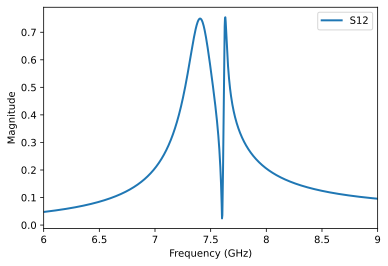

In [127]:
resonator_capacitance = c_rr[2] - ck_a -  c_r_a
options_a = {
    "qubit_c": [c_sigma_a],
    "qubit_l": [Lj_a],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[2]],
    "ck": [ck_a],
    "ck_to_ground": [cks_to_ground_a],
    "cqr": [c_r_a],
    "feedline_traits": transmission_line_tee_points_a,
    "cfl": cfl,
    "cfl_to_ground": cap_to_ground(cfl),
    "frequency": [6, 9],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a*1e-6,
    "b": b*1e-6,
    "ep_r": ep_r
}
cnx = assemble_network(options_a)
cir = rf.Circuit(cnx)

# cir.plot_graph(network_labels=True, network_fontsize=15,
#                port_labels=True, port_fontsize=15,
#                edge_fontsize=10)
ntw = cir.network
plt.figure(figsize = (6, 4))
ntw.plot_s_mag(m=0, n=1, lw=2)

# T1 Purcell for A

In [128]:
resonator_capacitance = c_rr[2] - ck_a -  c_r_a
options_purcell_a = {
    "qubit_c": [c_sigma_a],
    "qubit_l": [Lj_a],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[2]],
    "ck": [ck_a],
    "ck_to_ground": [cks_to_ground_a],
    "cqr": [c_r_a],
    "feedline_traits": transmission_line_tee_points_a,
    "cfl": cfl,
    "cfl_to_ground": cfl_to_ground,
    "frequency": [5, 6],
    "n_points": 3001,
    "type": "T1_Purcell_estimation",
    "decay_source": "readout_system",
    "a": a*1e-6,
    "b": b*1e-6,
    "ep_r": ep_r
}
cnx = assemble_network(options_purcell_s1)
cir = rf.Circuit(cnx)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network

In [131]:
freq_span_a = np.linspace(options_purcell_a["frequency"][0], options_purcell_a["frequency"][1], options_purcell_a["n_points"])
qb_idx = np.argmin(abs(freq_span_a - qubit_freq_target[2]/1e9))
Y_real_a = ntw.y[qb_idx, 0, 0].real
T1_a_readout_purcell_limit = c_sigma_s/Y_real_a
print(f"T1_s1_readout_purcell_limit: {T1_a_readout_purcell_limit*1e6} us")

T1_s1_readout_purcell_limit: 19676.511830681095 us


# Purcell from other lines

In [ ]:
# Fluxline
# Cap matrix
# 1 island close to line
# 2 island far from line
# 3 line
C11 = 162.48 - 40 - 0.62
C22 = 159.19 - 40.04 - 0.4921
C23 = 0.49218
C13 = 0.62657

C11 = 159.18 - 40.14 - 0.73450
C22 = 159.20 - 40.14 - 0.55341
C23 = 0.55341
C13 = 0.74350


C11 = 158.86- 40.07 - 0.689
C22 = 158.86 - 40.06 - 0.53217
C23 = 0.53217
C13 = 0.68899

c_eff_flux = (C13*C22 - C23*C11) / (C11 + C13 + C22 + C23) * 1e-15
c_eff_flux
gamma_flux = (2*np.pi*np.array(qubit_freq_target))**2*c_eff_flux**2*50/c_sigma_s
T1_flux = 1/gamma_flux
print(T1_flux*1e6)

# 234.9 flux quanta/A

[299.73938833 370.04862757 288.10014257]
